## Import Library

In [1]:
import findspark
findspark.init()

In [2]:
import nbformat

In [3]:
import os, sys
os.environ['DGLBACKEND'] = 'pytorch'
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import networkx as nx
import itertools
import plotly.express as px

from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import dgl
from itertools import combinations
%matplotlib inline

os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn
from dgl.dataloading import DataLoader
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import *+
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Bucketizer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

In [5]:
scala_version = '2.12'  # your scala version
spark_version = '3.5.0' # your spark version
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:3.6.0' #your kafka version
]
spark = SparkSession.builder.master("local").appName("kafka-example").config("spark.jars.packages", ",".join(packages)).getOrCreate()
spark

## Load Dataset

In [6]:
df_train = pd.read_csv('data/training.csv')
df_train['dataset'] = 'train'
df_test = pd.read_csv('data/test.csv')
df_test['dataset'] = 'test'

In [7]:
df = pd.concat([df_train, df_test], axis=0)

## Node Indexer

In [8]:
def column_index(series, offset=0):
    return {k: v+offset for v, k in enumerate(series.value_counts().index.values)}

In [9]:
def indexing(df): 
    txn2idx = {v: idx for idx, v in enumerate(df['TransactionId'].values)}
    acct2idx = column_index(df['AccountId'])
    sub2idx = column_index(df['SubscriptionId'])
    cust2idx = column_index(df['CustomerId'])
    df['txnIdx'] = df['TransactionId'].map(txn2idx)
    df = df.sort_values(by='txnIdx')
    df['acctIdx'] = df['AccountId'].map(acct2idx)
    df['subIdx'] = df['SubscriptionId'].map(sub2idx)
    df['custIdx'] = df['CustomerId'].map(cust2idx)
    return df

In [10]:
df = indexing(df)

In [11]:
df

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,dataset,txnIdx,acctIdx,subIdx,custIdx
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,1000.0,1000,2018-11-15T02:18:49Z,2,0.0,train,0,209,207,161
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-20.0,20,2018-11-15T02:19:08Z,2,0.0,train,1,0,0,161
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,500.0,500,2018-11-15T02:44:21Z,2,0.0,train,2,3660,3658,4066
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,20000.0,21800,2018-11-15T03:32:55Z,2,0.0,train,3,536,551,544
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-644.0,644,2018-11-15T03:34:21Z,2,0.0,train,4,0,0,544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45014,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-5000.0,5000,2019-03-14T23:56:28Z,2,NaN,test,140676,0,0,731
45015,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,...,10000.0,10000,2019-03-14T23:57:38Z,1,NaN,test,140677,806,790,762
45016,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,...,10000.0,10000,2019-03-14T23:59:17Z,1,NaN,test,140678,603,601,555
45017,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-5000.0,5000,2019-03-14T23:59:39Z,2,NaN,test,140679,0,0,555


## Construct nodes

In [12]:
def node_construct(df, categorical):
    #One-Hot Encoding for Categorical Features:
    X_ohe = pd.get_dummies(df[categorical].astype(str), drop_first=True).values
    #Binary Encoding for 'Amount' Feature:
    X_amt = ((df['Amount']>0)*1).values
    #Logarithmic Transformation for 'Value' Feature:
    X_value = df['Value'].apply(np.log10).values
    #concatenation of Numerical Features:
    X_num = np.concatenate([X_amt.reshape((-1,1)), X_value.reshape((-1,1))], axis=1)
    #Min-Max Scaling:
    X_num = (X_num - X_num.mean(axis=0))/(X_num.max(axis=0) - X_num.min(axis=0))
    node_feat = np.concatenate([X_ohe, X_num], axis=1)
    return node_feat

In [13]:
categorical = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
node_feat = node_construct(df, categorical)

## Construct edges

In [14]:
def edges_contruct(df, node_id_cols):
    edge_dict = dict()
    for src_type, dst_type in combinations(node_id_cols, 2):
        fwd = (src_type, f'{src_type}-{dst_type}', dst_type)
        bwd = (dst_type, f'{dst_type}-{src_type}', src_type)
        print(fwd)
        print(bwd)
        print('-'*50)
        print(df[[src_type, dst_type]])
        edges = df[[src_type, dst_type]].drop_duplicates().values
        src = edges[:,0]
        dst = edges[:,1]
        edge_dict[fwd] = (th.tensor(src), th.tensor(dst))
        edge_dict[bwd] = (th.tensor(dst), th.tensor(src))
    return edge_dict

In [15]:
node_id_cols = ['txnIdx', 'subIdx', 'acctIdx']
edge_dict = edges_contruct(df, node_id_cols)

('txnIdx', 'txnIdx-subIdx', 'subIdx')
('subIdx', 'subIdx-txnIdx', 'txnIdx')
--------------------------------------------------
       txnIdx  subIdx
0           0     207
1           1       0
2           2    3658
3           3     551
4           4       0
...       ...     ...
45014  140676       0
45015  140677     790
45016  140678     601
45017  140679       0
45018  140680     135

[140681 rows x 2 columns]
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-txnIdx', 'txnIdx')
--------------------------------------------------
       txnIdx  acctIdx
0           0      209
1           1        0
2           2     3660
3           3      536
4           4        0
...       ...      ...
45014  140676        0
45015  140677      806
45016  140678      603
45017  140679        0
45018  140680      135

[140681 rows x 2 columns]
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-subIdx', 'subIdx')
--------------------------------------------------
       subIdx  ac

## Construct Graph

In [16]:
def graph_construct(edge_dict, y_txn, X):
    hg = dgl.heterograph(edge_dict)
    label_feat = dict()
    for ntype in hg.ntypes:
        if ntype=='txnIdx':
            continue
        label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype))+baseline
        print(label_feat[ntype])
    label_feat['txnIdx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()
    hg.ndata['label'] = label_feat
    for ntype in hg.ntypes:
        if ntype=='txnIdx':
            X_tmp = th.tensor(X).float()
        else:
            X_rand = th.rand((hg.num_nodes(ntype), X.shape[1]-1))-0.5
            print(ntype, hg.num_nodes(ntype))
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if ntype==cetype[2]:
                    print(cetype)
                    in_degrees += hg.in_degrees(etype=cetype)
            in_degrees = th.log(in_degrees).reshape((-1, 1))
            in_degrees -= in_degrees.mean()
            X_tmp = th.hstack([X_rand, in_degrees])
        hg.nodes[ntype].data['feat'] = X_tmp
    return hg

In [17]:
y_txn = df.sort_values(by='txnIdx')['FraudResult'].values
baseline = y_txn[y_txn>=0].mean()
baseline

0.00201752001839811

In [18]:
hg = graph_construct(edge_dict, y_txn, node_feat)

tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020])
tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020])
acctIdx 4841
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
subIdx 4836
('acctIdx', 'acctIdx-subIdx', 'subIdx')
('txnIdx', 'txnIdx-subIdx', 'subIdx')


In [19]:
hg

Graph(num_nodes={'acctIdx': 4841, 'subIdx': 4836, 'txnIdx': 140681},
      num_edges={('acctIdx', 'acctIdx-subIdx', 'subIdx'): 4843, ('acctIdx', 'acctIdx-txnIdx', 'txnIdx'): 140681, ('subIdx', 'subIdx-acctIdx', 'acctIdx'): 4843, ('subIdx', 'subIdx-txnIdx', 'txnIdx'): 140681, ('txnIdx', 'txnIdx-acctIdx', 'acctIdx'): 140681, ('txnIdx', 'txnIdx-subIdx', 'subIdx'): 140681},
      metagraph=[('acctIdx', 'subIdx', 'acctIdx-subIdx'), ('acctIdx', 'txnIdx', 'acctIdx-txnIdx'), ('subIdx', 'acctIdx', 'subIdx-acctIdx'), ('subIdx', 'txnIdx', 'subIdx-txnIdx'), ('txnIdx', 'acctIdx', 'txnIdx-acctIdx'), ('txnIdx', 'subIdx', 'txnIdx-subIdx')])

## EDA

In [20]:
import networkx as nx

In [21]:
def draw_kkl_hg(hg, **kwargs):

    hg_label = hg.ndata['label']['txnIdx'].int()

    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    fig, ax = plt.subplots(figsize=(10,10))

    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))

    nodeShapes = ["^", "s", "o", "v"]
    # For each node class...
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype=='txnIdx':
            node_color = ['blue' if v==0 else 'red' if v==1 else 'black' for v in hg_label]
        else:
            node_color = "grey"
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist = [sNode[0] for sNode in nx_G.nodes(data=True) if sNode[1]["ntype"] == idx]
        )

    # Draw the edges between the nodes
    nx.draw_networkx_edges(nx_G, pos)

def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    for i, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        if i >= N_plots:
            break
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp)


def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return {
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }

    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2]==ntype:
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees

        hg.ndata['degree'] = degree_data
        hg.ndata['N_fraud'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }

        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_fraud', 'total_fraud'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_fraud', 'total_fraud_2hop'), cross_reducer='sum')

        n_2hop = hg.ndata['d_sum']['txnIdx']
        fraud_rate_2hop = hg.ndata['total_fraud_2hop']['txnIdx'] / hg.ndata['d_sum']['txnIdx']
    return n_2hop, fraud_rate_2hop

C:\Users\Windows\miniconda3\envs\my_env\lib\site-packages\dgl\dataloading\dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
C:\Users\Windows\miniconda3\envs\my_env\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


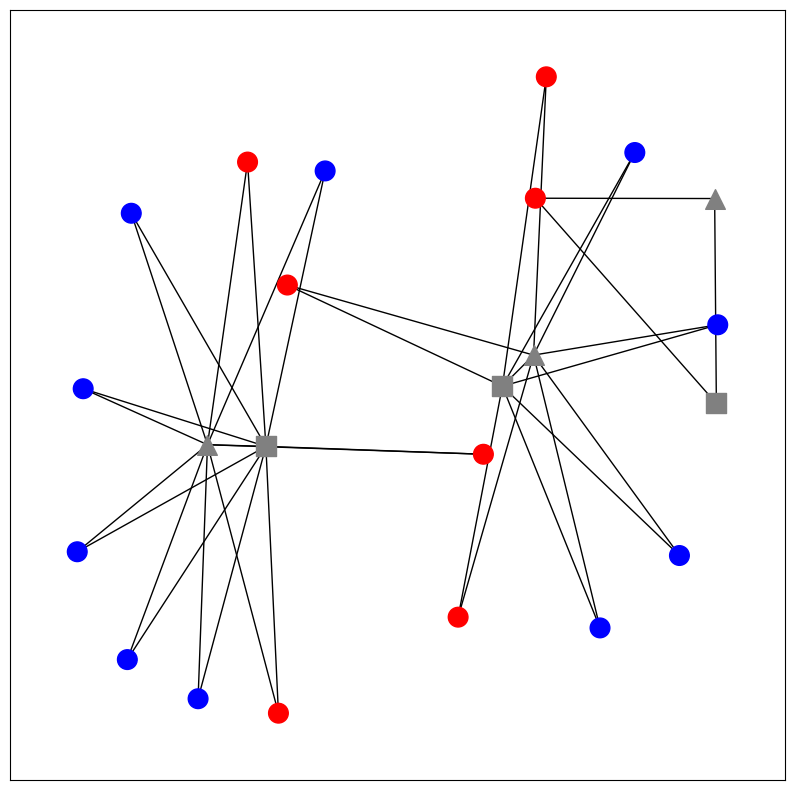

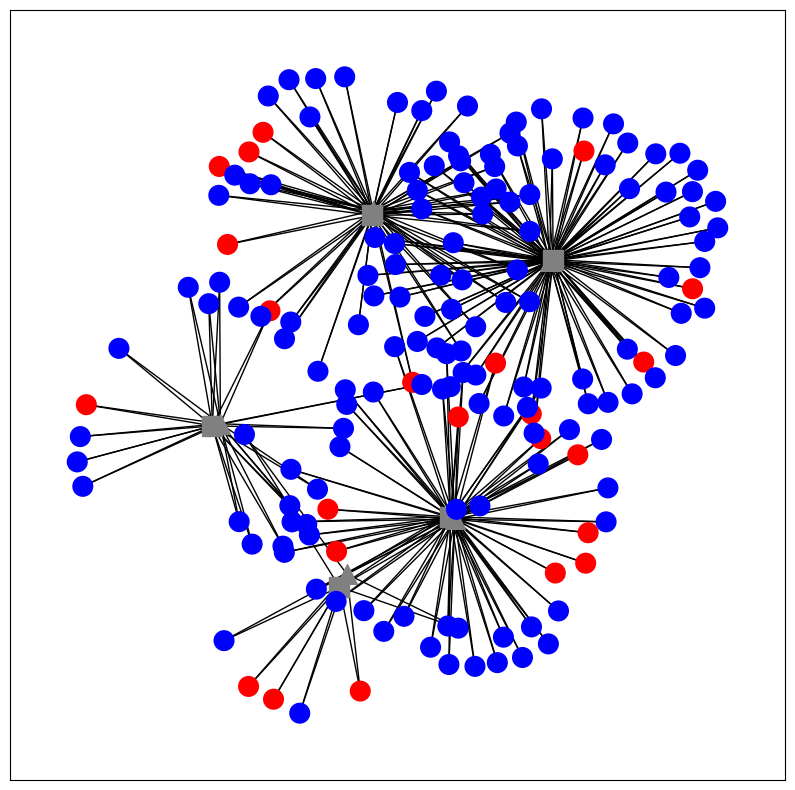

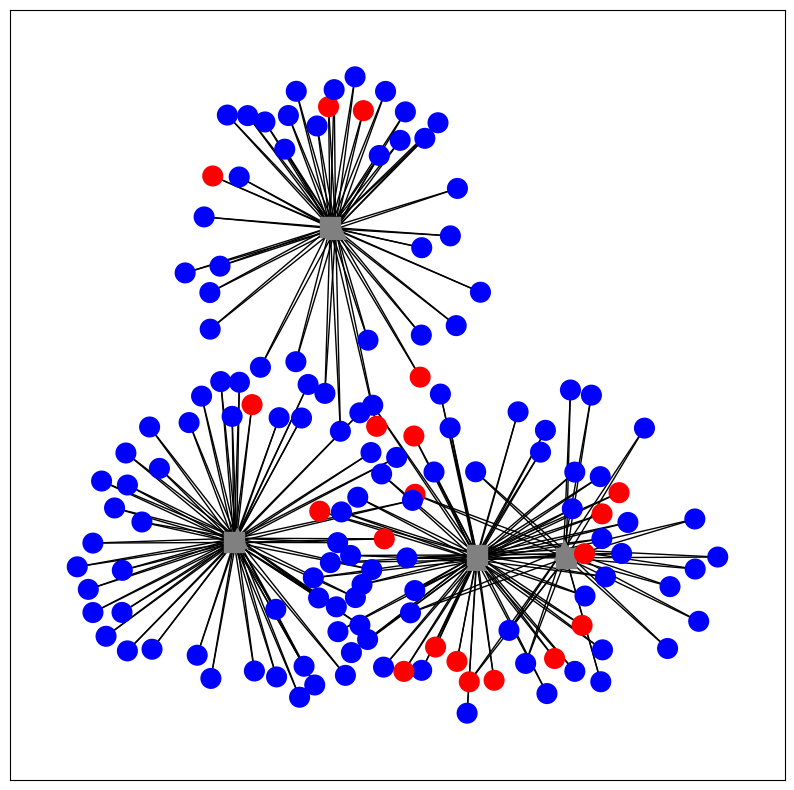

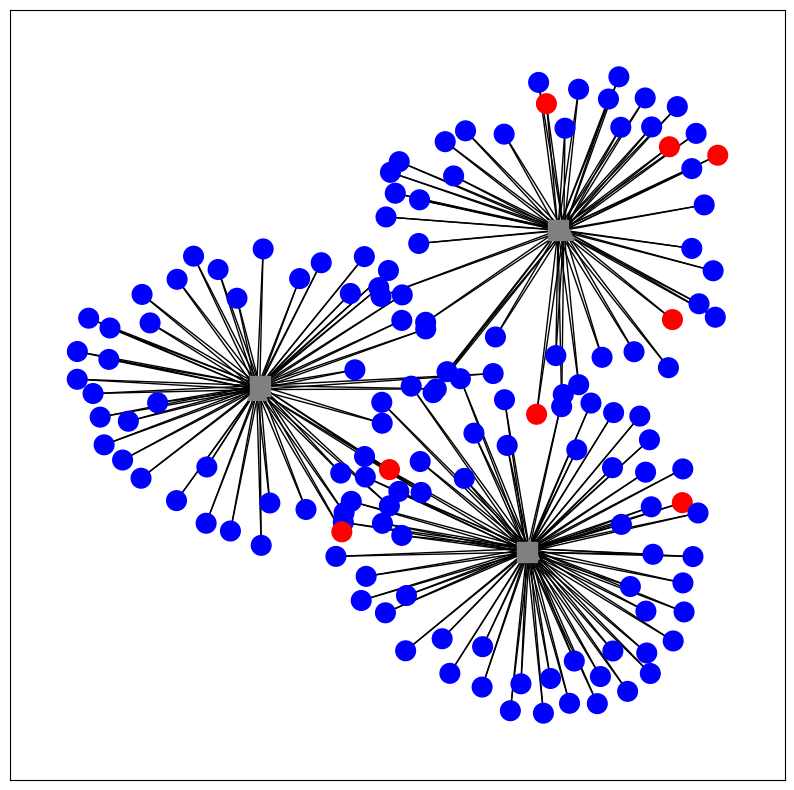

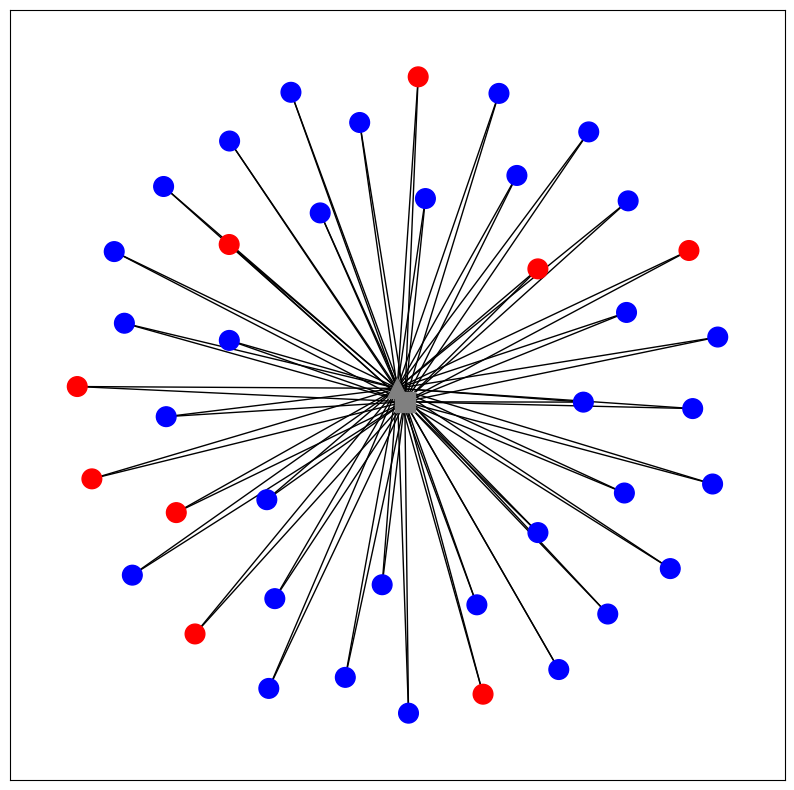

In [22]:
n_hops = 5
sampler = dgl.dataloading.MultiLayerNeighborSampler([10]*n_hops)
dataloader_legit = DataLoader(
    hg, {'txnIdx': np.where(y_txn==1)[0]}, sampler,
    batch_size=5, shuffle=False, drop_last=False, num_workers=0)
plot_neighborhood(dataloader_legit, N_plots=5)

## Split data

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

def plot_pr(y_trues, y_preds, labels):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        auc = roc_auc_score(y_true, y_pred)
        pr, re, thresholds = precision_recall_curve(y_true, y_pred)
        ax.plot(re, pr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

        f1_scores = 2*re*pr/(re+pr)
        print(labels[i])
        print('Best threshold: ', thresholds[np.argmax(f1_scores)])
        print('Best F1-Score: ', np.max(f1_scores))

    ax.legend()
    ax.grid()
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')
    
def plot_losses(train_losses, val_losses, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()

In [24]:
N_labels = df[df['dataset']=='train'].shape[0]
# Indicies w/ labels (training data)
labeled_mask = np.zeros_like(y_txn, dtype=bool)
labeled_mask[:N_labels] = 1

# Split of training data into train/validation sets
rng = np.random.default_rng(1)
train_rate = 0.7
train_mask = (rng.random(y_txn.shape[0])>(1-train_rate))&labeled_mask
val_mask = ~train_mask&labeled_mask
test_mask = ~labeled_mask
split_mask = {
    'train': th.tensor(train_mask),
    'valid': th.tensor(val_mask),
    'test': th.tensor(test_mask)
}

## GCN

In [25]:
@th.no_grad()
def infer(model_cp, hg, mask, best_model_fp=None):
    if best_model_fp:
        print("loading from disk")
        model = deepcopy(model_cp)
        model.load_state_dict(th.load(best_model_fp))
    else:
        model = model_cp

    model.to(device)

    model.eval()

    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    y_preds = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        y_preds.append(logits.softmax(dim=1))

    return th.cat(y_preds).cpu()

@th.no_grad()
def test(model, hg, mask, best_path=None):

    model.eval()

    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    labels = hg.ndata['label']['txnIdx'].long()

    correct = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        y_preds = logits.argmax(1)
        n_correct = (labels[output_nodes['txnIdx']] == y_preds).sum().item()
        correct.append(n_correct)

    correct_tensor = th.tensor(correct, dtype=th.float32, device=device)
    acc = correct_tensor.sum() / th.where(mask)[0].shape[0]

    return acc.item()

def train_step(model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight=False):
    """
    A single training step
    """
    model.train()
    optimizer.zero_grad()

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(train_mask)[0]}, sampler,
        batch_size=1024, shuffle=True, drop_last=False, num_workers=0)

    val_loader = DataLoader(
        hg, {'txnIdx': th.where(val_mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    train_losses = list()
    if weight:
        weight = th.tensor([1., 1/baseline]).float().to(device)
    else:
        weight = None

    labels = hg.ndata['label']['txnIdx'].long()

    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        loss = loss_fn(logits, labels[output_nodes['txnIdx']], weight=weight)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())


    val_losses = list()
    with th.no_grad():
        for input_nodes, output_nodes, blocks in val_loader:
            h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
            blocks = [b.to(device) for b in blocks]

            logits = model(blocks, h)
            val_loss = loss_fn(logits, labels[output_nodes['txnIdx']])
            val_losses.append(val_loss.item())

    return np.array(train_losses).mean(), np.array(val_losses).mean()

def train(hg, split_idx, model, epochs, evaluator,
          device, save_path, loss_fn=F.cross_entropy, lr=0.01,
          es_criteria=5, weight_class=False, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_metric = 1e10
    train_losses = list()
    val_losses = list()
    train_accuracies = list()
    val_accuracies = list()
    features = hg.ndata['feat']

    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    es_iters = 0

    for e in range(1, epochs+1):

        # print("Training step")
        train_loss, val_loss = train_step(
            model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight_class,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute accuracy on training/validation/test
        # print("Train eval")
        train_acc = test(model, hg, train_mask)
        # print("Val eval")
        val_acc = test(model, hg, val_mask)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        val_metric = val_loss

        if val_metric > 1e5:
            print(f"Early stopping for huge loss: {val_metric}")
            break

        # Save the best validation accuracy and the corresponding test accuracy.
        if val_metric < best_val_metric  :
            best_val_metric = val_metric
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1


        if e % 5 == 0 and verbose:
            print('In epoch {}, loss: {:.3f}, val metric: {:.3f} (best {:.3f}), train_acc {:.3f}, val_acc {:.3f}'.format(
                e, train_loss, val_metric, best_val_metric, train_acc, val_acc))

        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break

    return np.array(train_losses), np.array(val_losses), np.array(train_accuracies), np.array(val_accuracies)

In [26]:
from dgl.nn import GraphConv, HeteroGraphConv, WeightBasis
class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 *,
                 num_bases=None,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 bn=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.bn = bn

        self.conv = HeteroGraphConv({
                rel : GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
                for rel in rel_names
            })

        self.use_weight = weight
        self.use_basis = num_bases is not None and num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        if self.bn:
            self.bn_layer = nn.BatchNorm1d(out_feat)

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.bn:
                h = self.bn_layer(h)
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [27]:
class RGCN(nn.Module):
    def __init__(self, hg, in_feats, h_feats, num_classes, num_layers, num_bases,
                 self_loop=True, dropout=0, bn=False):

        super(RGCN, self).__init__()
        self.dropout = dropout

        # GNN layers
        self.convs = nn.ModuleList()
        activation_fn = nn.ReLU()
        self.convs.append(RelGraphConvLayer(
            in_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout,
            num_bases=num_bases, self_loop=self_loop, bn=bn))

        for _ in range(num_layers-1):
            self.convs.append(RelGraphConvLayer(
                h_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout,
                num_bases=num_bases, self_loop=self_loop, bn=bn
            ))

        # Output linear layer
        self.output_layer = nn.Linear(h_feats+in_feats, num_classes)

    def forward(self, blocks, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features

        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat
        for i, conv in enumerate(self.convs):
            h = conv(blocks[i], h)

        h_in = blocks[-1].dstdata['feat']['txnIdx']
        h = self.output_layer(th.cat([h['txnIdx'], h_in], dim=1))
        return h


class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target, weight=None):
        logprobs = nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [28]:
model_kwargs = dict(
    in_feats=node_feat.shape[1], h_feats=256, num_classes=2,
    num_layers=2, dropout=0.1, num_bases=None,
    self_loop=False, bn=True,
)
model = RGCN(hg, **model_kwargs).to(device)
model

RGCN(
  (convs): ModuleList(
    (0): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (acctIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
        )
      )
      (bn_layer): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subI

In [29]:
# loss_fn = LabelSmoothing(smoothing=0.1)
# train_losses, val_losses, train_accuracies, val_accuracies = train(
#     hg.to(device), split_mask, model.to(device), 20, None,
#     device, 'models/rgcn.pt', loss_fn=loss_fn, lr=0.001,
#     es_criteria=50, verbose=True, weight_class=True,
# )

In [30]:
# plot_losses(train_losses, val_losses, log=True)

In [31]:
# predictions using a trained model.
y_val_hat_rgcn = infer(model.to(device), hg.to(device), split_mask['valid'].to(device), 'models/rgcn.pt')

loading from disk


C:\Users\Windows\AppData\Local\Temp\ipykernel_22912\52926542.py:26: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*re*pr/(re+pr)


RGCN
Best threshold:  0.3169964
Best F1-Score:  nan


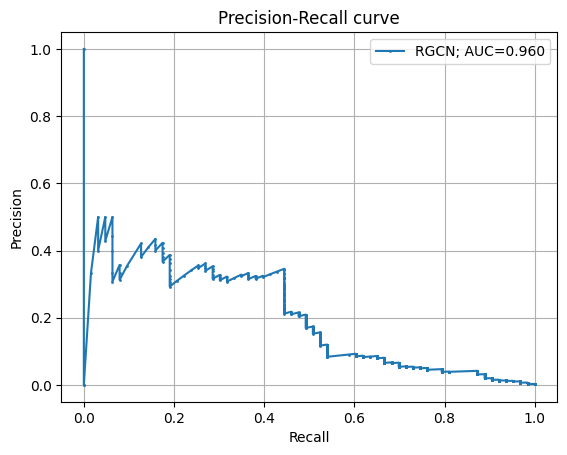

In [32]:
plot_pr(
    [y_txn[val_mask]]*5,
    [y_val_hat_rgcn[:,1]],
    ['RGCN'],
)

In [33]:
unique_values, counts = np.unique(y_val_hat_rgcn[:,1], return_counts=True)

# Printing the counts of unique values
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.05038522556424141, Count: 1
Value: 0.05777879059314728, Count: 1
Value: 0.05847683548927307, Count: 1
Value: 0.060277171432971954, Count: 2
Value: 0.060298267751932144, Count: 1
Value: 0.060381095856428146, Count: 1
Value: 0.06126583367586136, Count: 1
Value: 0.061486825346946716, Count: 1
Value: 0.061497073620557785, Count: 1
Value: 0.062267981469631195, Count: 1
Value: 0.06266695261001587, Count: 1
Value: 0.06324134767055511, Count: 1
Value: 0.06324262917041779, Count: 1
Value: 0.06328191608190536, Count: 1
Value: 0.06334062665700912, Count: 1
Value: 0.06336544454097748, Count: 1
Value: 0.06360052525997162, Count: 1
Value: 0.06362762302160263, Count: 1
Value: 0.06371837854385376, Count: 1
Value: 0.06393823772668839, Count: 1
Value: 0.0640171617269516, Count: 1
Value: 0.06402472406625748, Count: 1
Value: 0.06407944113016129, Count: 1
Value: 0.06411339342594147, Count: 1
Value: 0.06414283066987991, Count: 1
Value: 0.06430882960557938, Count: 1
Value: 0.0643644630908966, Count:

Value: 0.09449798613786697, Count: 1
Value: 0.0945008397102356, Count: 1
Value: 0.0945015698671341, Count: 1
Value: 0.09450209885835648, Count: 1
Value: 0.09450368583202362, Count: 1
Value: 0.09450758248567581, Count: 1
Value: 0.09451062232255936, Count: 1
Value: 0.09451433271169662, Count: 1
Value: 0.09451492130756378, Count: 1
Value: 0.09451667219400406, Count: 1
Value: 0.09451822191476822, Count: 1
Value: 0.09452470391988754, Count: 1
Value: 0.094527967274189, Count: 1
Value: 0.09452860802412033, Count: 1
Value: 0.09453319013118744, Count: 1
Value: 0.09453858435153961, Count: 1
Value: 0.0945388525724411, Count: 1
Value: 0.0945393443107605, Count: 1
Value: 0.09454270452260971, Count: 1
Value: 0.09454397112131119, Count: 1
Value: 0.09454689174890518, Count: 1
Value: 0.09455224126577377, Count: 1
Value: 0.0945534035563469, Count: 2
Value: 0.09455554932355881, Count: 1
Value: 0.09455672651529312, Count: 1
Value: 0.09455978125333786, Count: 1
Value: 0.09457103908061981, Count: 1
Value: 0

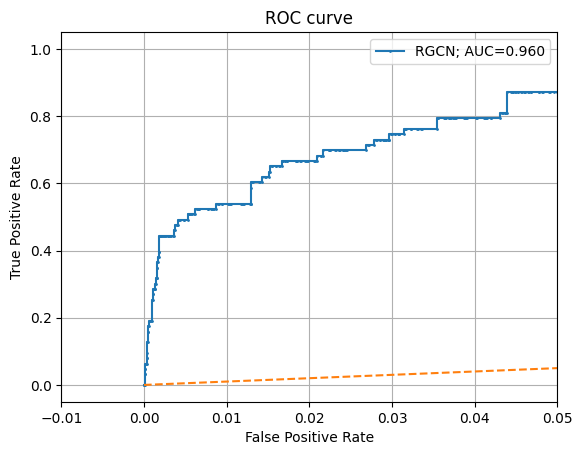

In [34]:
plot_roc(
    [y_txn[val_mask]]*5,
    [y_val_hat_rgcn[:,1]],
    ['RGCN'],
    x_max=0.05,
)

In [35]:
import time
from random import randint
from IPython.display import clear_output
from pyspark.sql.functions import from_json
import plotly.express as px
from kafka import KafkaConsumer
from time import sleep
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

In [36]:
def predict_from_probabilities(y_probs):
    # Use argmax to get the index of the class with the highest probability
    
    predicted_classes = th.argmax(y_probs, dim=1)
    return predicted_classes

def get_corresponding_mask(df, df_transformed):
    df_unique_ids = df["TransactionId"].drop_duplicates()
    transaction_id_list = df_unique_ids.tolist()
    
    df_final = df_transformed.copy()
    df_final["mask"] = df_final["TransactionId"].isin(transaction_id_list)
    
    mask = df_final["mask"].values.astype(bool)
    return mask

In [37]:
# Define the schema for Kafka stream DataFrame
schema = StructType([
    StructField("TransactionId", StringType(), True),
    StructField("BatchId", StringType(), True),
    StructField("AccountId", StringType(), True),
    StructField("SubscriptionId", StringType(), True),
    StructField("CustomerId", StringType(), True),
    StructField("CurrencyCode", StringType(), True),
    StructField("CountryCode", IntegerType(), True),
    StructField("ProviderId", StringType(), True),
    StructField("ProductId", StringType(), True),
    StructField("ProductCategory", StringType(), True),
    StructField("ChannelId", StringType(), True),
    StructField("Amount", DoubleType(), True),
    StructField("Value", IntegerType(), True),
    StructField("TransactionStartTime", TimestampType(), True),
    StructField("PricingStrategy", IntegerType(), True)
])

kafka_params = {
    "kafka.bootstrap.servers": "localhost:9092",  # Change this to your Kafka broker
    "subscribe": "test_streaming",               # Change this to your Kafka topic
    "startingOffsets": "earliest"
}

In [38]:
np.bool = np.bool_
# Read streaming data from Kafka
kafka_stream_df = (
    spark.read.format("kafka")
    .option("kafka.bootstrap.servers", kafka_params["kafka.bootstrap.servers"])
    .option("subscribe", kafka_params["subscribe"])
    .option("startingOffsets", kafka_params["startingOffsets"])
    .load()
    .selectExpr("CAST(value AS STRING)")
    .select(from_json("value", schema).alias("data"))
    .select("data.*")
)

kafka_stream_df = kafka_stream_df.dropDuplicates().toPandas()

In [39]:
mask = get_corresponding_mask(kafka_stream_df, df)
tensor_mask = th.tensor(mask)
y_pred = infer(model.to(device), hg.to(device), tensor_mask.to(device) , 'models/rgcn.pt')
y_pred_labels = (y_pred[:, 1] > 0.21062215).int().numpy()
kafka_stream_df["Fraud_Predict"] = y_pred_labels

loading from disk


In [77]:
import plotly.express as px
def display_live_plot(df):
    # Create a scatter plot for fraudulent transactions
    fraud_df = df[df['Fraud_Predict'] == 1]
    fig = px.scatter(fraud_df, x="TransactionStartTime", y="Amount", color="Fraud_Predict", title="Live Streaming Data")
    
    # Overlay line plot for all transactions
    line_fig = px.line(df, x="TransactionStartTime", y="Amount", title="Live Streaming Data")
    
    # Update scatter plot with line plot data
    for trace in line_fig.data:
        fig.add_trace(trace)\
        
    fig.update_layout(
        autosize=False,
        width=1000, 
        height=400, 
    )
    fig.show()

batch_size = 5000  
previous_batch = None
for x in range(0, 4):  
    try:
        print("Showing live view refreshed every 5 seconds")
        print(f"Seconds passed: {x*5}")
        current_batch = kafka_stream_df.sample(batch_size) 
        if previous_batch is not None:
            combined_df = pd.concat([previous_batch, current_batch])
            display_live_plot(combined_df)
        else:
            display_live_plot(current_batch)
        previous_batch = current_batch
        sleep(5)  
        clear_output(wait=True)
    except KeyboardInterrupt:
        print("Break")
        break

print("Live view ended.")

Live view ended.
